In [22]:
import pandas as pd
import numpy as np
import seaborn as sb
import copy
import pandas_profiling
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder as ohe, LabelEncoder as le
import warnings
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report as cr
%matplotlib inline
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv('forModel.csv')

In [17]:
df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,...,long,location,season,avg_high_temp (C),avg_low_temp (C),avg_precipitation (inches),snow (inches),unemployement_rate,Day,Night
0,I192068249,2647,other,threats to do bodily harm,B2,280,0,2015-08-28,2015,8,...,-71.084251,"(42.33011862, -71.08425106)",summer,26.444444,-3.086420,1.58,0.0,0.0,1,0
1,I192061894,1106,confidence games,fraud - credit card / atm fraud,C11,356,0,2015-08-20,2015,8,...,-71.061268,"(42.30060543, -71.06126785)",summer,26.444444,-3.086420,1.58,0.0,0.0,0,1
2,I192038828,1107,fraud,fraud - impersonation,A1,172,0,2015-11-02,2015,11,...,-71.072395,"(42.33428841, -71.07239518)",fall,10.722222,-11.820988,1.80,1.3,3.7,1,0
3,I192008877,1107,fraud,fraud - impersonation,E18,525,0,2015-07-31,2015,7,...,-71.129566,"(42.23700950, -71.12956606)",summer,26.666667,-2.962963,4.03,0.0,0.0,1,0
4,I182090828,1102,fraud,fraud - false pretense / scheme,D4,159,0,2015-12-01,2015,12,...,-71.072258,"(42.34243222, -71.07225766)",winter,2.555556,-16.358025,2.49,9.2,3.7,1,0


In [18]:
df.shape

(581169, 25)

In [19]:
df.season.unique()

array(['summer', 'fall', 'winter', 'spring'], dtype=object)

In [20]:
partOne = list(set(df.groupby('ucr_part').get_group('Part One')['offense_code']))
partTwo = list(set(df.groupby('ucr_part').get_group('Part Two')['offense_code']))
partThree = list(set(df.groupby('ucr_part').get_group('Part Three')['offense_code']))
partOther = list(set(df.groupby('ucr_part').get_group('Other')['offense_code']))

In [23]:
for i in tqdm(df.index):
    if df['offense_code'][i] in partOne:
        df['offense_code'][i] = 'serious_crime'
    elif df['offense_code'][i] in partTwo:
        df['offense_code'][i] = 'intermediate_crime'
    elif df['offense_code'][i] in partThree:
        df['offense_code'][i] = 'low_level_crime'
    elif df['offense_code'][i] in partOther:
        df['offense_code'][i] = 'other_crime'

100%|███████████████████████████████████████████████████████████████████████| 581169/581169 [00:11<00:00, 49006.05it/s]


In [25]:
df['unemployement_rate'].nunique()

16

##  We will trying predict how much case will occure a day.

## We will create with dataframe included district, occured on date, incident number (counted by days& district),day of week for modelling.

## If we add the Ucr_part and Hour features, they do not increase the score of our model. We do not include these to reduce complexity.


In [40]:
df_reg = pd.DataFrame(df.groupby(["occurred_on_date","district", "day_of_week"])["incident_number"].count()).reset_index()
df_reg.head()



,occurred_on_date,district,day_of_week,incident_number
0,2015-06-15,A1,Monday,23
1,2015-06-15,A15,Monday,5
2,2015-06-15,A7,Monday,10
3,2015-06-15,B2,Monday,34
4,2015-06-15,B3,Monday,26


In [41]:
df_reg.day_of_week.nunique()

7

In [42]:
df_reg.isnull().sum()

occurred_on_date    0
district            0
day_of_week         0
incident_number     0
dtype: int64

In [50]:
df_reg.head()

,occurred_on_date,district,day_of_week,case_count
0,2015-06-15,A1,1,23
1,2015-06-15,A15,1,5
2,2015-06-15,A7,1,10
3,2015-06-15,B2,1,34
4,2015-06-15,B3,1,26


In [49]:
df_reg.rename(columns = {'incident_number' : 'case_count'}, inplace = True)

In [44]:
df_reg['day_of_week'] = df_reg['day_of_week'].map({'Monday' : 1,
                                                  'Tuesday' : 2,
                                                  'Wednesday':3,
                                                  'Thursday' : 4,
                                                  "Friday" : 5,
                                                  'Saturday' : 6,
                                                  'Sunday' : 7})

In [51]:
df_reg = pd.concat([df_reg, pd.get_dummies(df_reg['district'], prefix = 'D')]
                   , axis = 1)

In [75]:
df_reg = pd.concat([df_reg, pd.get_dummies(df_reg['day_of_week'], prefix = 'day')]
                   , axis = 1)

In [53]:
df_reg.drop('district', axis = 1, inplace = True)

In [76]:
df_reg.drop('day_of_week', axis = 1, inplace = True)

In [77]:
df_reg

,occurred_on_date,case_count,D_A1,D_A15,D_A7,D_B2,D_B3,D_C11,D_C6,D_D14,...,D_E18,D_E5,D_External,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,735764,23,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,735764,5,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,735764,10,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,735764,34,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,735764,26,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31830,738397,2,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
31831,738397,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
31832,738397,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
31833,738397,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [57]:
df_reg["D_A1"] = np.int64(df_reg["D_A1"])
df_reg["D_A15"] = np.int64(df_reg["D_A15"])
df_reg["D_A7"] = np.int64(df_reg["D_A7"])
df_reg["D_B2"] = np.int64(df_reg["D_B2"])
df_reg["D_B3"] = np.int64(df_reg["D_B3"])
df_reg["D_C11"] = np.int64(df_reg["D_C11"])
df_reg["D_C6"] = np.int64(df_reg["D_C6"])
df_reg["D_D14"] = np.int64(df_reg["D_D14"])
df_reg["D_D4"] = np.int64(df_reg["D_D4"])
df_reg["D_E13"] = np.int64(df_reg["D_E13"])
df_reg["D_E18"] = np.int64(df_reg["D_E18"])
df_reg["D_E5"] = np.int64(df_reg["D_E5"])
df_reg["D_External"] = np.int64(df_reg["D_External"])


In [78]:
df_reg["day_1"] = np.int64(df_reg["day_1"])
df_reg["day_2"] = np.int64(df_reg["day_2"])
df_reg["day_3"] = np.int64(df_reg["day_3"])
df_reg["day_4"] = np.int64(df_reg["day_4"])
df_reg["day_5"] = np.int64(df_reg["day_5"])
df_reg["day_6"] = np.int64(df_reg["day_6"])
df_reg["day_7"] = np.int64(df_reg["day_7"])

In [59]:
df_reg['occurred_on_date'] = pd.to_datetime(df_reg['occurred_on_date'])

In [79]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31835 entries, 0 to 31834
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   occurred_on_date  31835 non-null  int64
 1   case_count        31835 non-null  int64
 2   D_A1              31835 non-null  int64
 3   D_A15             31835 non-null  int64
 4   D_A7              31835 non-null  int64
 5   D_B2              31835 non-null  int64
 6   D_B3              31835 non-null  int64
 7   D_C11             31835 non-null  int64
 8   D_C6              31835 non-null  int64
 9   D_D14             31835 non-null  int64
 10  D_D4              31835 non-null  int64
 11  D_E13             31835 non-null  int64
 12  D_E18             31835 non-null  int64
 13  D_E5              31835 non-null  int64
 14  D_External        31835 non-null  int64
 15  day_1             31835 non-null  int64
 16  day_2             31835 non-null  int64
 17  day_3             31835 non-nul

In [66]:
df_reg['occurred_on_date'] = df_reg['occurred_on_date'].apply(lambda x: x.toordinal())

In [80]:
df_reg

,occurred_on_date,case_count,D_A1,D_A15,D_A7,D_B2,D_B3,D_C11,D_C6,D_D14,...,D_E18,D_E5,D_External,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,735764,23,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,735764,5,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,735764,10,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,735764,34,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,735764,26,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31830,738397,2,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
31831,738397,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
31832,738397,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
31833,738397,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [84]:
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [81]:
x = df_reg.drop('case_count', axis = 1)
y = df_reg['case_count']

In [82]:
x_train, x_test, y_train, y_test = tts(x, y, test_size = 20, random_state = 142)

In [83]:
lr = LinearRegression().fit(x_train, y_train)
pred = lr.predict(x_test)
print(r2_score(y_test, pred))

0.41339741456368706


In [90]:
xgb = XGBRegressor(n_estimators = 200).fit(x_train, y_train)
pred = xgb.predict(x_test)
print(r2_score(y_test, pred))

0.5937286492993276


In [69]:
for i in x.columns:
    if df[i].nunique() > 2 and df[i].nunique() < 15:
        df[i] = df[i].astype('category')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21116 entries, 0 to 21115
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   incident_number             21116 non-null  object  
 1   offense_code                21116 non-null  category
 2   offense_code_group          21116 non-null  object  
 3   offense_description         21116 non-null  object  
 4   district                    21116 non-null  category
 5   reporting_area              21116 non-null  object  
 6   shooting                    21116 non-null  int64   
 7   occurred_on_date            21116 non-null  object  
 8   year                        21116 non-null  category
 9   month                       21116 non-null  category
 10  day_of_week                 21116 non-null  category
 11  hour                        21116 non-null  int64   
 12  ucr_part                    21116 non-null  object  
 13  street          

In [32]:
len(df.offense_code.unique())

4

In [72]:
df.drop(['incident_number', 'offense_code_group', 'offense_description', 'occurred_on_date', 'street', 'location'], axis = 1, inplace = True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21116 entries, 0 to 21115
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   offense_code                21116 non-null  category
 1   district                    21116 non-null  category
 2   reporting_area              21116 non-null  object  
 3   shooting                    21116 non-null  int64   
 4   year                        21116 non-null  category
 5   month                       21116 non-null  category
 6   day_of_week                 21116 non-null  category
 7   hour                        21116 non-null  int64   
 8   ucr_part                    21116 non-null  object  
 9   lat                         21116 non-null  float64 
 10  long                        21116 non-null  float64 
 11  season                      21116 non-null  category
 12  avg_high_temp (C)           21116 non-null  category
 13  avg_low_temp (C)

In [33]:
"""data_profile = pandas_profiling.ProfileReport(df)
data_profile.to_file(output_file = 'final_Data_Profile.html')"""


"data_profile = pandas_profiling.ProfileReport(df)\ndata_profile.to_file(output_file = 'final_Data_Profile.html')"

In [34]:
new_df = copy.deepcopy(df)

In [35]:
new_df = new_df[['offense_code', 'district', 'shooting', 'month', 'day_of_week', 'hour', 'ucr_part', 'lat', 'long']]

In [36]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21116 entries, 0 to 21115
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   offense_code  21116 non-null  object 
 1   district      21116 non-null  object 
 2   shooting      21116 non-null  int64  
 3   month         21116 non-null  int64  
 4   day_of_week   21116 non-null  object 
 5   hour          21116 non-null  int64  
 6   ucr_part      21116 non-null  object 
 7   lat           21116 non-null  float64
 8   long          21116 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 1.5+ MB


In [37]:
df['ucr_part'].dtype

dtype('O')

In [38]:
enc = le()
for i in new_df.columns:
    if new_df[i].dtype == 'O':
        new_df[i] = enc.fit_transform(df[i])

In [50]:
new_df

,offense_code,district,shooting,month,day_of_week,hour,ucr_part,lat,long
0,0,8,0,12,5,12,3,42.342432,-71.072258
1,0,10,0,12,5,12,3,42.268897,-71.108137
2,0,3,0,12,5,12,3,42.323410,-71.093396
3,0,4,0,12,5,0,3,42.279971,-71.095534
4,3,2,0,12,5,0,1,42.370818,-71.039291
...,...,...,...,...,...,...,...,...,...
21111,1,0,0,1,2,1,2,42.359330,-71.053550
21112,3,0,0,1,2,0,1,42.360688,-71.056873
21113,0,11,0,1,2,0,3,42.292092,-71.121089
21114,3,8,0,1,2,0,1,42.346251,-71.099539


<AxesSubplot:>

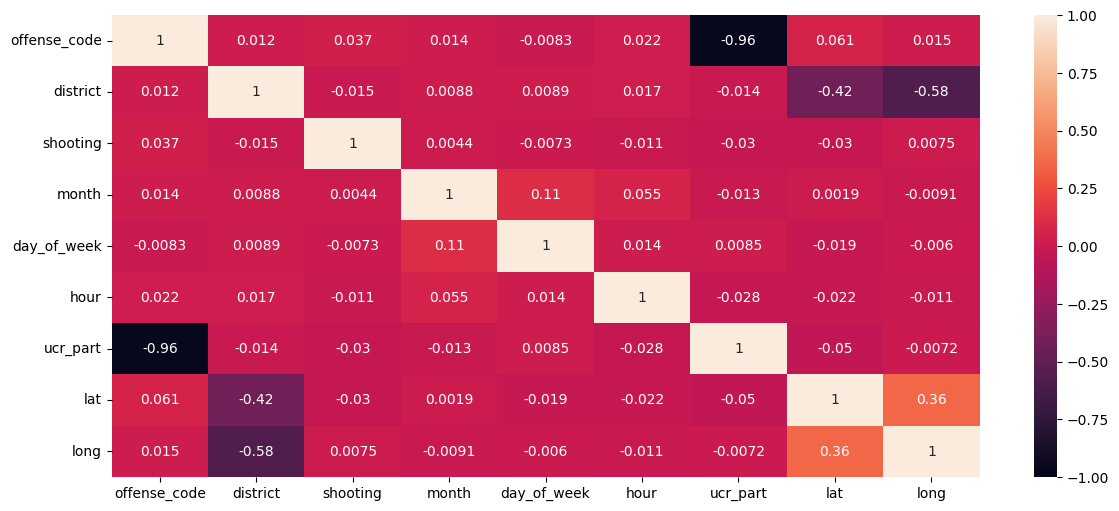

In [40]:
plt.figure(figsize = (14,6))
sb.heatmap(new_df.corr(), vmin = -1, vmax = 1, annot = True)

In [41]:
x = new_df.drop('ucr_part', axis = 1)
y = new_df['ucr_part']

In [42]:
x_train, x_test, y_train, y_test = tts(x,y, test_size = 0.25)

In [43]:
y_train.value_counts()

2    7838
3    5028
1    2917
0      54
Name: ucr_part, dtype: int64

In [44]:
over_sample = SMOTE(n_jobs = -1)
x_train,y_train= over_sample.fit_resample(x_train,y_train)

In [45]:
dtc = DecisionTreeClassifier().fit(x_train, y_train)
pred = dtc.predict(x_test)
pred

array([3, 2, 2, ..., 1, 1, 2])

In [46]:
print(cr(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00       972
           2       1.00      1.00      1.00      2601
           3       1.00      1.00      1.00      1689

    accuracy                           1.00      5279
   macro avg       1.00      1.00      1.00      5279
weighted avg       1.00      1.00      1.00      5279



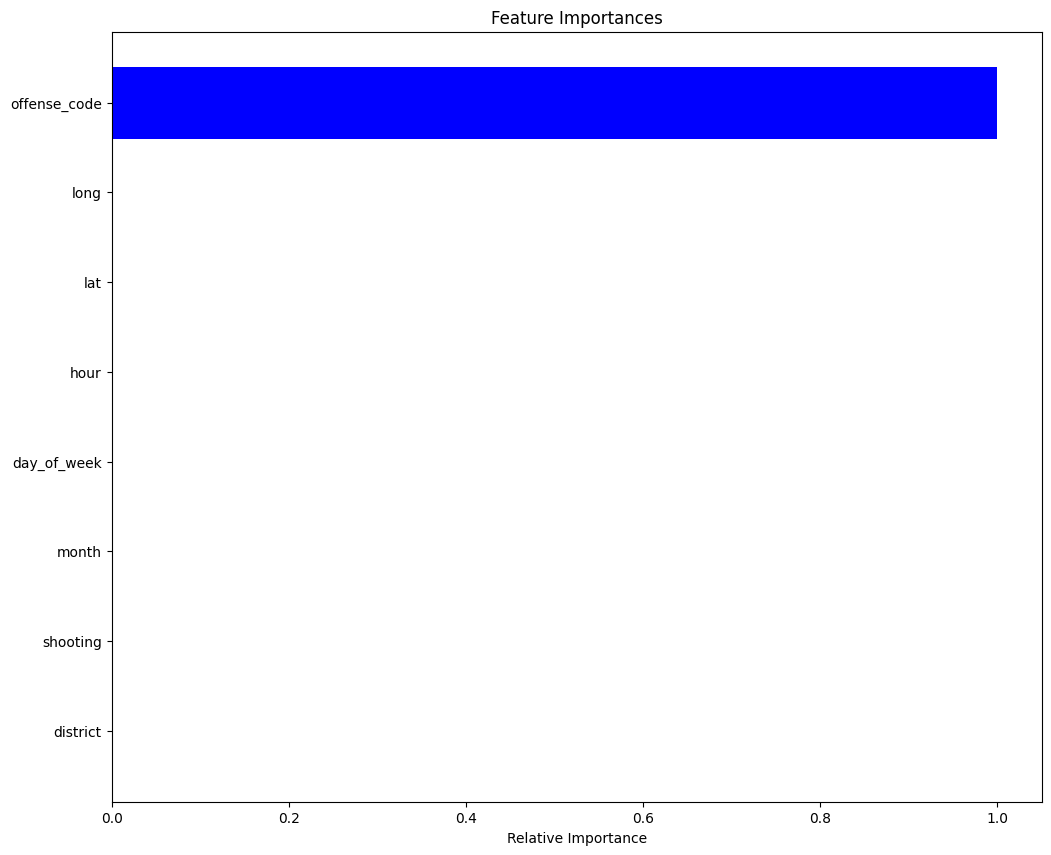

In [47]:
feature_names = list(x.columns)
importances = dtc.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12, 10))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="blue", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [48]:
from sklearn.feature_selection import VarianceThreshold

In [49]:
selector = VarianceThreshold()
selector.fit_transform(x_train)

array([[  0.        ,   5.        ,   0.        , ...,  16.        ,
         42.30839354, -71.06473124],
       [  0.        ,   4.        ,   0.        , ...,  11.        ,
         42.29276044, -71.07486603],
       [  1.        ,   3.        ,   0.        , ...,  10.        ,
         42.32866284, -71.08563401],
       ...,
       [  0.        ,   9.        ,   0.        , ...,  15.        ,
         42.31603034, -71.09781673],
       [  0.        ,  11.        ,   0.        , ...,  12.        ,
         42.28721378, -71.14757726],
       [  0.        ,   2.        ,   0.        , ...,   9.        ,
         42.34117031, -71.0847324 ]])

In [9]:
 from tqdm import tqdm

In [13]:
a = [1,2,3]

In [14]:
for i in tqdm(a):
    pass

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
